In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Joachim DAVID december 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)
from visualize_lib import plot_gantt, show_energy_plot

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
file_used = 'productionfile.csv'

round_to = 600 # seconds
break_pauses = 7200 # seconds
turn_off_if = 3600 # seconds !!!! has to be smaller than the breaks indicated here

In [3]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [4]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
# reasons_relative = [1, 3, 5, 7, 8]
# reasons_absolute = [9, 10, 11]
# reasons_not_considered = [2]
# group = True
choice='PastaType'

In [5]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES', 'HORENTJE', 'HELICES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'MIE', 'NONE']
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

In [6]:
df

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,PastaType
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.000,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.000,8,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
3,50,50675.0,74525.0,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
4,50,50675.0,74525.0,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177.000,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
5,50,50675.0,74525.0,2016-01-19 19:44:53.073,2016-01-19 19:49:18.047,265.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
6,0,0.0,0.0,2016-01-19 19:49:18.047,2016-01-21 09:56:44.780,137246.733,0,NaN,000000EU,NONE,Break,NONE
7,50,50724.0,74711.0,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126.000,9,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,MACARONI
8,50,50724.0,74711.0,2016-01-21 09:58:50.930,2016-01-21 10:51:08.090,3138.000,1,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",RunTime,MACARONI
9,50,50724.0,74711.0,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294.000,8,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,MACARONI


### Export for simulator file and visualise

In [7]:
def add_breaks(production, maxtime=7200):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE'})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [8]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
#df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task, maxtime=break_pauses)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName
0,50675,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64,10,MACARONI KORT PLATTE ZAK
1,50675,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860,100,MACARONI KORT PLATTE ZAK
2,50675,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414,8,MACARONI KORT PLATTE ZAK
3,50675,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871,100,MACARONI KORT PLATTE ZAK
4,50675,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177,10,MACARONI KORT PLATTE ZAK


In [9]:
df_task.ProductionRequestId.unique()

array([50675.0, -1, -2, ..., 77326.0, -2284, 77248.0], dtype=object)

In [10]:
prodtime = df_task.Duration[df_task.ArticleName != 'NONE'].sum() / 3600
idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600

print('Production time {:.3f} h'.format(prodtime))
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13218.464 h
Idle time 3121.736 h
Total time 16340.199 h


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\visualize_lib.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_task['Start'] = (df_task[startdate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600
D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\visualize_lib.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_task['End'] = (df_task[enddate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600


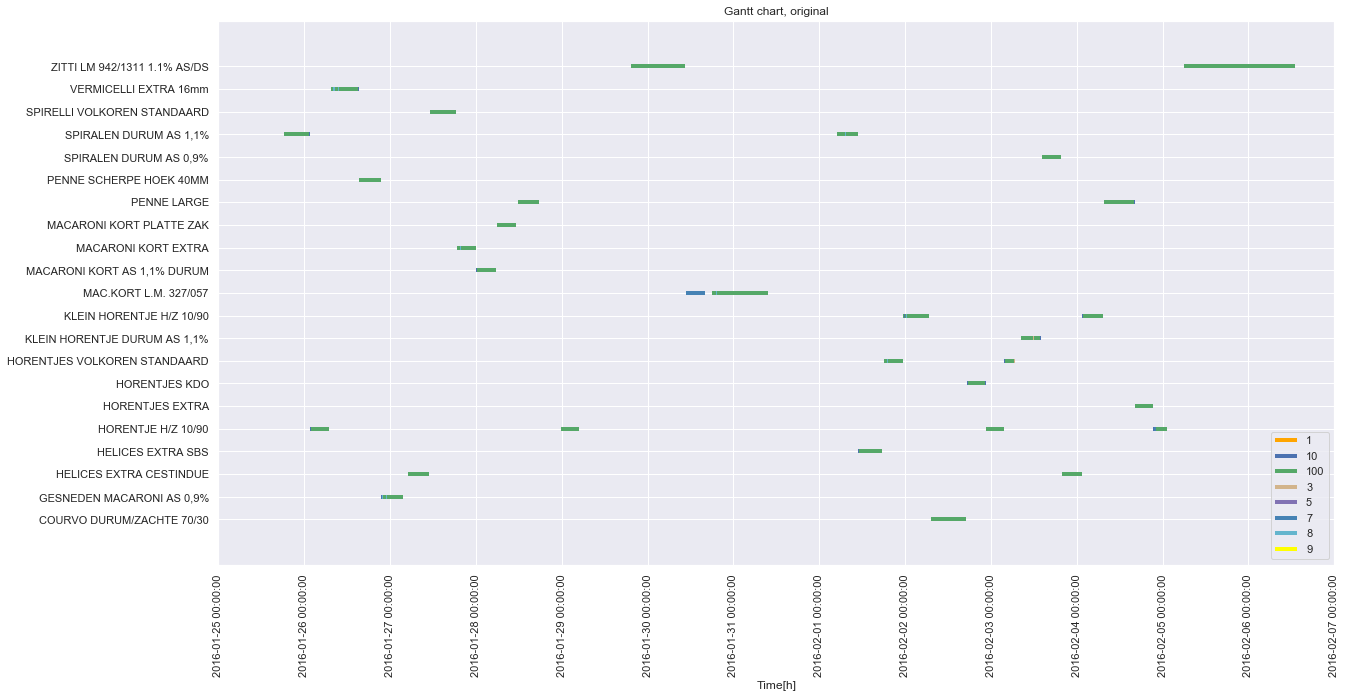

In [11]:
plt.figure(figsize=(20, 10))
# df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
# df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
df_part = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
plot_gantt(df_part, 'ReasonId', 'ArticleName')
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# key_list = sorted(by_label)
# value_list = [by_label[key] for key in key_list]
# plt.legend(value_list, key_list, loc='lower right')
plt.title('Gantt chart, original')
plt.savefig('D:/temp/gantt.png', dpi=300, bbox_inches='tight')
plt.show()

In [12]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [13]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    group_uptime = df_task[df_task.ReasonId == 100].groupby('ProductionRequestId').agg({'Duration':'sum'})
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'})
    group = pd.concat([group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.Duration = group.Duration
    group.index = group.index.astype(int)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    #df['Duration'] = df['Duration'] * 60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    df['Duration'] = round(df['Duration'] / num_minutes) * num_minutes # rounds down to the chosen numbers of seconds
    i = 0
    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
        if i == 0:
            df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 's')
            df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[j, 'Duration'])
            i += 1
        df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
        df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(seconds = df.loc[k, 'Duration'])
    df = df[df['Duration'] > 0]
    #df['Duration'] = df['Duration']/60
    return df

def remove_breaks(group, min_length=3600):
    df = group.copy()
    j = 0
    while j < len(df):
        temp = df.iloc[j]
        if (temp['ArticleName'] == 'NONE') & (temp['Duration'] < min_length):
            # don't turn off the machine (no energy saving)
            curidx = temp.name
            previdx = df.iloc[j-1].name
            if (j > 0) & (df.loc[previdx, 'ArticleName'] != 'NONE'):
                df.loc[previdx, 'EndDateUTC'] = df.loc[curidx, 'EndDateUTC']
                df.loc[previdx, 'Duration'] += df.loc[curidx, 'Duration']
                df = df.drop(curidx)
                j -= 1
            else:
                pass
                #print('Something unexpected happened!')
                #print(curidx, df.loc[previdx, 'ArticleName'])
        j += 1
    return df
                    

def save_durations(group, output):
    out = group.copy()
    out.columns = ['Duration', 'Start', 'End', 'Product']
    out['Duration'] = out['Duration'] / 3600
    for col in ['Start', 'End']:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.insert(3, 'Quantity', 20)
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    out.index.name = 'ID'
    out.to_csv(output)

group = group_productions(df_task)
group = simplify_productions(group, 600)
group = remove_breaks(group, 3600)

In [14]:
prodtime = group.Duration[group.ArticleName != 'NONE'].sum() / 3600
print('Production time {:.3f} h'.format(prodtime))
idletime = group.Duration[group.ArticleName == 'NONE'].sum() / 3600
print('Idle time {:.3f} h'.format(idletime))
print('Total time {:.3f} h'.format(prodtime + idletime))

Production time 13295.333 h
Idle time 3044.667 h
Total time 16340.000 h


In [15]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'))
# reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
# group['ReasonId'] = reasonlist

In [16]:
def energy_per_production(group):
    articlenum = len(group.ArticleName.unique())
    rand = np.random.random_sample((articlenum,)) * 0.2 + 0.1
    energycons = pd.concat([pd.Series(group.ArticleName.unique()), pd.Series(rand)], axis=1)
    energycons.columns = ['Product', 'Power']
    energycons.insert(1, 'UnitPrice', 5)
    energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    return energycons

energycons = energy_per_production(group)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [17]:
energycons.head()

,Product,UnitPrice,Power,TargetProductionRate
0,MACARONI KORT PLATTE ZAK,5,0.224269,3000
1,NONE,5,0.000000,3000
2,"GESNEDEN MACARONI AS 0,9%",5,0.248870,3000
3,PENNE SCHERPE HOEK 40MM,5,0.227561,3000
4,KLEIN HORENTJE H/Z 10/90,5,0.283666,3000


In [18]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [19]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

In [20]:
group.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,
50675,19800.0,2016-01-19 14:20:00,2016-01-19 19:50:00,MACARONI KORT PLATTE ZAK
-1,7200.0,2016-01-19 19:50:00,2016-01-19 21:50:00,NONE
-2,7200.0,2016-01-19 21:50:00,2016-01-19 23:50:00,NONE
-3,7200.0,2016-01-19 23:50:00,2016-01-20 01:50:00,NONE
-4,7200.0,2016-01-20 01:50:00,2016-01-20 03:50:00,NONE


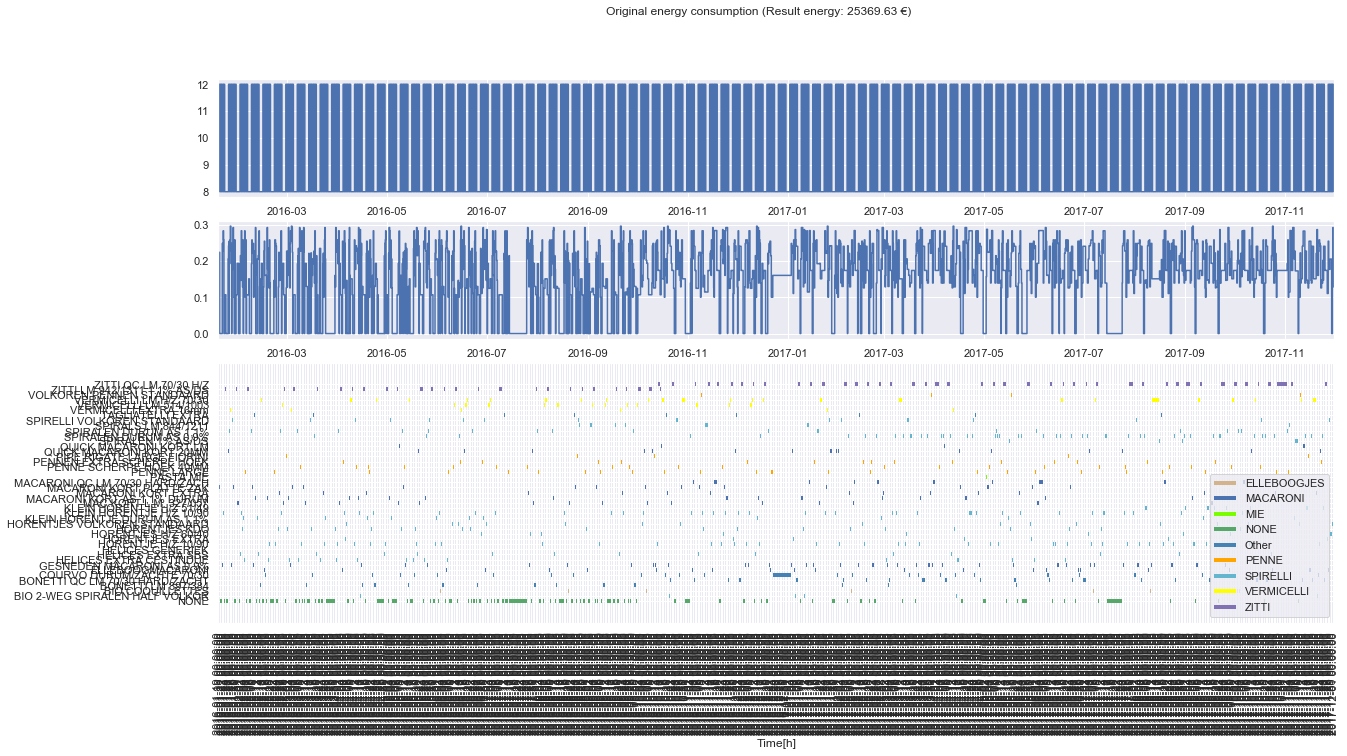

In [21]:
plt.figure(figsize=(20, 10))
c, table = calculate_energy_cost(group, prices, energycons, True)

plt.subplot(4,1,(3,4))
timerange = plot_gantt(add_column_type(group, choice='PastaType'), 'PastaType', 'ArticleName')

plt.subplot(4,1,1)
plt.suptitle('Original energy consumption (Result energy: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(4,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
plt.show()

In [22]:
def reorder_schedule(id_list, schedule):
    startdate = schedule.iloc[0]['StartDateUTC']
    df = schedule.loc[id_list]
    #print(df)
    for row in df.T:
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Duration'], unit='h')
        df.loc[row, 'EndDateUTC'] = enddate
        startdate = enddate
    return df

In [23]:
start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
start_time, end_time

(Timestamp('2016-01-19 14:20:00'), Timestamp('2017-11-30 10:20:00'))

In [28]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
best_result, orig_result, best_sched, orig_sched, best_curve, worst_curve = run_opt(start_time, end_time, 
       [], [],
        *files, 
        1, 2000, 0.4, 0.4, 12, weight_conversion = 0, weight_before = 0, num_mutations=2, adaptive=[],
            stop_condition='num_iterations', stop_value=None, weight_energy = 1)

Unexpected error when reading down duration information from '[]'


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:1056: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  warnings.warn('Import of downtime durations failed, using scheduling without failure information.')


1999/2000:	24821.046322998416
Elapsed time: 2176.97 s

Candidate schedule [ -163  -681  -373 ... 65326 -1045 58067]
Candidate failure cost: 0
Candidate energy cost: 24821.046322998416
Candidate conversion cost: 0
Candidate deadline cost 0
Candidate total cost: 24821.046322998416

Original schedule: [50675, -1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, 50724, 50708, 50740, 50742, -24, -25, -26, -27, -28, -29, 50830, -30, -31, -32, -33, -34, -35, -36, -37, -38, -39, -40, -41, -42, -43, -44, -45, -46, 50909, 50908, -48, 50910, 50703, 50741, 50912, 50913, 50877, -54, 50926, 50925, 51037, 51036, 51099, 50676, -60, -61, -62, -63, 51098, -64, -65, -66, -67, -68, -69, -70, -71, 51166, 50831, -73, -75, -76, -77, -78, -79, -80, -81, -82, -83, -84, 51216, 51215, 51209, 51210, 51214, 51213, 51211, 51207, -92, 51212, 51262, 51304, 51306, 51298, 51354, 51352, -98, -99, -100, 51350, 51353, -102, -103, -104, -105, -106, -107, -108, -109, -110, -111, -112, -

In [26]:
group_opt = reorder_schedule(best_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

NameError: name 'best_sched' is not defined

In [ ]:
plt.plot(best_curve)
plt.plot(worst_curve)

In [ ]:
show_energy_plot(group_opt, prices, energycons, 'Best schedule (GA)', 'PastaType')
plt.show()

In [ ]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [ ]:
# df_task.Resource.unique()

In [ ]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [ ]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours